In [3]:
%run ../setup_notebook.ipynb

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "numba_utilities7.py", line 296:
@njit(signature0,parallel=True)
def erf_times_gauss_numba0(x):
^

  self.func_ir.loc))
/home/thijs/repos/dnp-code/PGM7/numba_utilities7.py:703: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights,V)/sum_weights
/home/thijs/repos/dnp-code/PGM7/numba_utilities7.py:862: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T,V)
/home/thijs/repos/dnp-code/PGM7/numba_utilities7.py:863: NumbaPerformanceWarning: np.d

Recording from /home/thijs/Desktop/20180912_Run01_spontaneous_rbm2.h5
Fraction not burst: 0.892670628489105


In [4]:
import matplotlib.image as mpimg

In [12]:
# im_path = '/home/thijs/optogen_stim_variance.png'
# img = mpimg.imread(im_path)
# img.shape

## PCA & ICA

In [26]:
### PCA & ICA
all_nr_methods = []
weights = {}
# mapping = {}
# inverse_mapping = {}
n_comps = {'wb': 100}
bool_pca, bool_ica, bool_fa = True, False, False

def add_new_methods(name, region):
    assert weights[name].shape[0] < weights[name].shape[1]
    print(weights[name].shape, name)
#     mapping[name] = lambda high_data, w=weights[name]: np.dot(w, high_data)
#     inverse_mapping[name] = lambda low_data, w=weights[name].transpose(): np.dot(w, low_data)
    all_nr_methods.append(name)
#     low_dyn_test[name] = mapping[name](test_data[region])
#     low_dyn_train[name] = mapping[name](train_data[region])
#     low_dyn_full[name] = mapping[name](full_data[region])
    
for ir, r in enumerate(list(n_comps.keys())):
    if bool_pca:
        pca_model = sklearn.decomposition.PCA(n_components=n_comps[r])
        pca_model.fit(np.transpose(train_data[r]))
        print(pca_model)
        model_name = f'pca' 
        weights[model_name] = pca_model.components_
        add_new_methods(name=model_name, region=r)

    if bool_ica:
        ica_model = sklearn.decomposition.FastICA(n_components=n_comps[r])
        ica_model.fit(np.transpose(train_data[r]))
        print(ica_model)
        model_name = f'ica' 
        weights[model_name] = ica_model.components_
        add_new_methods(name=model_name, region=r)
    
    if bool_fa:
        fa_model = sklearn.decomposition.FactorAnalysis(n_components=n_comps[r])
        fa_model.fit(np.transpose(train_data[r]))
        print(fa_model)
        model_name = f'fa'
        weights[model_name] = fa_model.components_
        add_new_methods(name=model_name, region=r)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
(100, 52518) pca


In [27]:
rbm_path = '/home/thijs/Desktop/RBM7ADAM_20180912_Run01_spontaneous_rbm2_wb_train0-4000_M100_l1-1e-02_nit100000_nmc15_duration190300s_timestamp2019-07-30-0406.data'
RBM = pickle.load(open(rbm_path, 'rb'))
weights['rbm'] = RBM.weights.copy()

In [29]:
plot_methods = [ 'pca', 'rbm']
weighted_labels = {}

plot_labels = rec.labels[inds_wb, :].A
ind_regions = set(np.where(plot_labels.sum(0))[0])
ind_regions = np.array(list(ind_regions.difference(set([0, 93, 113, 218, 219, 220, 221, 222, 223, 224, 259, 274]))))
plot_labels = np.squeeze(plot_labels[:, ind_regions])

def freq_distr_weighted_regions(w_vector, m_labels):
    w_vector = np.abs(w_vector)
    weighted_labels = np.dot(w_vector, m_labels)
    weighted_labels = weighted_labels / m_labels.sum(0)
    weighted_labels = weighted_labels / np.sum(weighted_labels)
    return weighted_labels

def freq_entropy(prob_distr):
    prob_distr = prob_distr / np.sum(prob_distr)
    prob_distr += 1e-15  # to solve zero issue
    log_p = np.log2(prob_distr)
    tmp = prob_distr * log_p
    entropy = -1 * np.sum(tmp)
    return entropy 

def p_metric_per_hu(w_vector):
    w_vector = np.squeeze(w_vector)
#     assert w_vector.dim == 1
    p = np.power(np.sum(np.power(w_vector, 2)), 2) / np.sum(np.power(w_vector, 4))
    p = p / len(w_vector)
    return np.squeeze(p)

sparsity_vector = {}
for dr in plot_methods:
    sparsity_vector[dr] = np.zeros(weights[dr].shape[0])
    for mu in range(weights['rbm'].shape[0]):
        weighted_labels[dr] = freq_distr_weighted_regions(w_vector=weights[dr][mu, :], m_labels=plot_labels)
        sparsity_vector[dr][mu] = p_metric_per_hu(weighted_labels[dr]) * len(weighted_labels[dr])


0.7670437352061272

In [41]:
## Prepare panel 3BC orgiinal thesis
w_th_arr = {}; curve_NVUgeqKw = {}; sh_curve_NVUgeqKw = {}; #w_th_arr
K_arr = np.array([1, 2, 3, 5, 10])
perc_bottom = 0.01/100
perc_top= 100 - perc_bottom
n_w_th = 250

for dr in tqdm(weights.keys()):
    n_hidden, n_sel_cells = weights[dr].shape
    
#     w_th_arr[dr] = np.linspace(np.percentile(np.abs(weights[dr]), perc_bottom), np.percentile(np.abs(weights[dr]), perc_top), n_w_th)
    w_th_arr[dr] = np.linspace(0, np.percentile(np.abs(weights[dr]), 99.9), n_w_th)
    shuffled_weights = weights[dr].reshape(n_sel_cells * n_hidden)  # reshape
    shuffled_inds = np.arange(n_sel_cells * n_hidden)  # create new idns
    np.random.shuffle(shuffled_inds)  # shuffle 
    shuffled_weights = shuffled_weights[shuffled_inds]  # resample 
    shuffled_weights = shuffled_weights.reshape(n_hidden, n_sel_cells)  # reshape
    
    curve_NVUgeqKw[dr] = {K: np.zeros_like(w_th_arr[dr]) for K in K_arr} # number of hu with geq K connections greater than threshold w
    sh_curve_NVUgeqKw[dr] = {K: np.zeros_like(w_th_arr[dr]) for K in K_arr}   # number of hu with geq K connections greater than threshold w
    #     curve_NHUgeqKw = {dr: {K: np.zeros_like(w_th_arr) for K in K_arr} for dr in ['rbm_wb', 'pca_wb', 'ica_wb']} # number of hu with geq K connections greater than threshold w
    
    for iloop, w_th in enumerate(w_th_arr[dr]):
        for iK, K in enumerate(K_arr):
            wmat_th = np.abs(weights[dr]) > w_th
            sh_wmat_th = np.abs(shuffled_weights) > w_th
    #         wmat_th_perHU = np.sum(wmat_th, axis=1)
            wmat_th_perVU = np.sum(wmat_th, axis=0)
            sh_wmat_th_perVU = np.sum(sh_wmat_th, axis=0)
    #         curve_NHUgeqKw[K][iloop] = np.sum(wmat_th_perHU >= K)
            curve_NVUgeqKw[dr][K][iloop] = np.sum(wmat_th_perVU >= K) / float(n_sel_cells) * 100.0
            sh_curve_NVUgeqKw[dr][K][iloop] = np.sum(sh_wmat_th_perVU >= K) / float(n_sel_cells) * 100.0

100%|██████████| 2/2 [01:47<00:00, 53.96s/it]


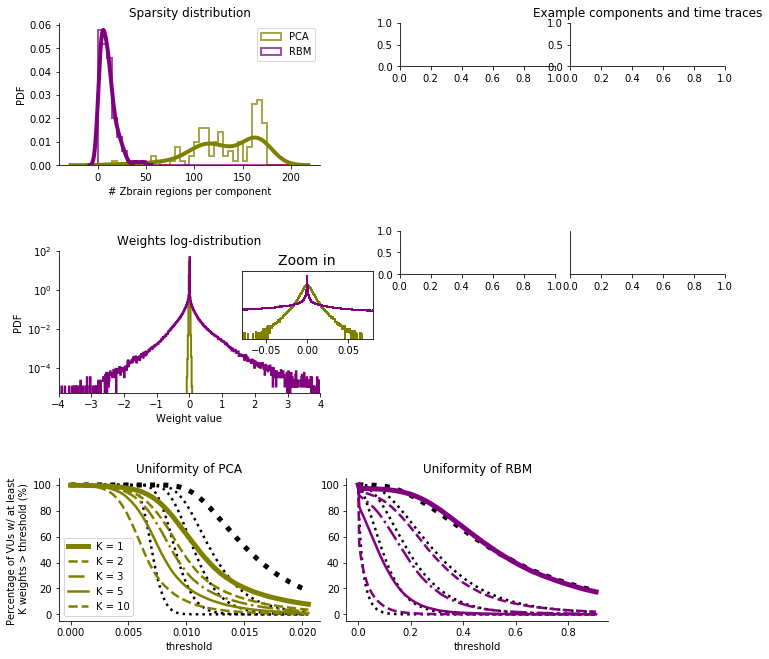

In [42]:
plt.rcParams['figure.figsize'] = (15, 11)
plt.subplots_adjust(hspace=0.6, wspace=0.1)
save_fig = False

mu_arr = {'rbm': [25, 14], 'pca': [0, 5], 'ica': [0, 21]} #  1 ,3
# plot_methods = [ 'pca', 'ica', 'rbm']


## Time plots
sax = {}; iplot=0
# time_slice = slice(0, 500)
for i_dr, dr in enumerate(plot_methods):
    for i_mu, mu in enumerate(mu_arr[dr]):
        weighted_labels[dr] = freq_distr_weighted_regions(w_vector=weights[dr][mu, :], m_labels=plot_labels)
        iplot += 1
        sax[iplot] = plt.subplot(9, 5, int(i_dr + 3 + (i_mu*15)))
    #         sax[iplot].plot(weighted_labels[dr], label=f'{dr_legend[dr]}, S={np.round(freq_entropy(weighted_labels[dr]), 2)}',
    #                         linewidth=1, alpha=1, color=dr_colors[dr])
#         sax[iplot].plot(low_dyn_test[dr][mu, time_slice], linewidth=1, color=dr_colors[dr])
#         sax[iplot].get_yaxis().set_visible(False); sax[iplot].get_yaxis().set_ticks([])
#         sax[iplot].get_xaxis().set_visible(False); sax[iplot].get_xaxis().set_ticks([])
    #     plt.xlabel('Region id'); #plt.ylabel('P(region)'); plt.title(f'Example P(region) for HU {mu}')
        if i_dr == 1 and i_mu == 0:
            plt.title('Example components and time traces')

## Sparsity of regions
plt.subplot(331)
plot_bins = np.arange(0, len(ind_regions), 5)
for dr in plot_methods:
    #     plt.hist(sparsity_vector[dr], bins=plot_bins, label=dr)
    sns.distplot(sparsity_vector[dr], hist=True, kde=True, bins=plot_bins,
                 label=dr_legend[dr], color=dr_colors[dr], 
                 kde_kws={'linewidth': 4}, hist_kws={'histtype':'step', 'linewidth':2, 'alpha':0.7, 'density':True})
plt.legend(); plt.xlabel('# Zbrain regions per component'); plt.ylabel('PDF'); plt.title('Sparsity distribution');


## Weights distribution
ax_mainw = plt.subplot(334)
plot_bins = np.linspace(np.min([weights[x].min() for x in weights.keys()]), 
                        np.max([weights[x].max() for x in weights.keys()]), 1000)
for dr in plot_methods:
    ax_mainw.hist(np.ravel(weights[dr]), bins=plot_bins, histtype='step', label=dr_legend[dr],
             density=True, linewidth=2, color=dr_colors[dr])
plt.yscale('log'); plt.xlabel('Weight value'); plt.ylabel('PDF'); plt.title('Weights log-distribution')
plt.xlim([-4, 4])

## Weights distribution Zoom inset
ax_zoomw = ax_mainw.inset_axes([0.7, 0.38, 0.5, 0.48])
for dr in plot_methods:
    ax_zoomw.hist(np.ravel(weights[dr]), bins=np.linspace(-0.11, 0.11, 500), histtype='step', label=dr_legend[dr],
             density=True, linewidth=2, color=dr_colors[dr])
# ax_zoomw.plot(np.arange(4))
ax_zoomw.get_yaxis().set_visible(False); sax[iplot].get_yaxis().set_ticks([])
# ax_zoomw.get_xaxis().set_visible(False); sax[iplot].get_xaxis().set_ticks([])
ax_zoomw.set_yscale('log'); ax_zoomw.set_xlim([-0.08, 0.08]); ax_zoomw.set_ylim([1e-4, 5e3])
ax_zoomw.set_title('Zoom in', fontdict={'size': 14})
    
plot_bins = np.arange(25) - 0.5
perc = 99

# for i_dr, dr in enumerate(plot_methods):
#     plt.subplot(3, 3, 7+int(i_dr))
#     shuffled_weights = weights[dr].reshape(weights[dr].shape[0] * weights[dr].shape[1])  # reshape
#     shuffled_inds = np.arange(weights[dr].shape[0] * weights[dr].shape[1])  # create new idns
#     np.random.shuffle(shuffled_inds)  # shuffle 
#     shuffled_weights = shuffled_weights[shuffled_inds]  # resample 
#     shuffled_weights = shuffled_weights.reshape(weights[dr].shape[0], weights[dr].shape[1])  # reshape
#     plt.hist(np.sum(np.abs(shuffled_weights) > np.percentile(np.ravel(weights[dr]), perc), axis=0), bins=plot_bins, 
#              color='k', histtype='step', density=True, linewidth=3)
#     plt.hist(np.sum(np.abs(weights[dr]) > np.percentile(np.ravel(weights[dr]), perc), axis=0), bins=plot_bins, 
#              color=dr_colors[dr], histtype='step', density=True, linewidth=3)
    
for i_dr, dr in enumerate(plot_methods):
    plt.subplot(3, 3, 7 + i_dr)
    linestyles = {1: '-', 2: '--', 3: '-.', 5: '-', 10: '--'}
    linewidths = {1: 5, 2:2.5, 3:2.5, 5:2.5, 10:2.5}
    for iK, K in enumerate(K_arr):
        plt.plot(w_th_arr[dr], sh_curve_NVUgeqKw[dr][K], ':', color='black', linewidth=linewidths[K]);
    for iK, K in enumerate(K_arr):  
        plt.plot(w_th_arr[dr], curve_NVUgeqKw[dr][K], linestyle=linestyles[K],
                 label= 'K = ' + str(K), linewidth=linewidths[K], color=dr_colors[dr]);
#         print(K)
#         print(scipy.stats.ks_2samp(curve_NVUgeqKw[dr][K], sh_curve_NVUgeqKw[dr][K]))
    
    plt.title(f'Uniformity of {dr_legend[dr]}')
    plt.xlabel('threshold');
    if i_dr == 0:
        plt.ylabel('Percentage of VUs w/ at least \n K weights > threshold (%)'); plt.legend();

sns.despine()
if save_fig:
    plt.savefig('/home/thijs/repos/rbm_code/new_figures/manuscript/figure3/20180912-Run01/full_fig2.svg')